# Exploratory Data Analysis with R and BigQuery
## Overview

This notebook illustrates how to perform Exploratory Data Analysis (EDA) using R, on data extracted from BigQuery. After you analyze and process the data, the transformed data is stored in Cloud Storage for further ML tasks.

R is one of the most widely used programming languages for statistical modeling. It has a large and active community of data scientists and machine learning (ML) professionals. With over 15,000 packages in the open-source repository of CRAN, R has tools for all statistical data analysis applications, ML, and visualization.

## Dataset
The dataset used in this tutorial is the BigQuery natality dataset. This public dataset includes information about more than 137 million births registered in the United States from 1969 to 2008. The dataset is available [here](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=samples&t=natality&page=table&_ga=2.99329886.-1705629017.1551465326&_gac=1.109796023.1561476396.CI2rz-z4hOMCFc6RhQods4oEXA).

In this notebook, we focus on Exploratory Data Analysis, while the goal is to predict the baby's weight given a number of factors about the pregnancy and the baby's mother.

## Objective
The goal of this tutorial is to:
1. Create an AI Platform Notebooks instance that has R support.
2. Query and analyze data from BigQuery using the bigrquery R library.
3. Prepare and store data in Cloud Storage for ML.

## Costs
This tutorial uses the following billable components of Google Cloud:
1. BigQuery
2. AI Platform Notebooks instance
3. Cloud Storage

Use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.


In [1]:
version

               _                           
platform       x86_64-conda_cos6-linux-gnu 
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          3                           
minor          6.3                         
year           2020                        
month          02                          
day            29                          
svn rev        77875                       
language       R                           
version.string R version 3.6.3 (2020-02-29)
nickname       Holding the Windsock        

## 0. Setup 

Import the required libraries, all of which have been pre-installed in an R notebook.

In [2]:
# import R libraries
library(bigrquery) # used for querying BigQuery
library(ggplot2) # used for visualisation
library(dplyr) # used for data wrangling

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Use BigQuery out-of-band authentication

In [3]:
bq_auth(use_oob = TRUE)

Invalid encoding utf8: defaulting to UTF-8.



Set your `PROJECT_ID` and `BUCKET_NAME`

In [4]:
# Set the project id
PROJECT_ID <- "gcp-data-science-demo"

# Set your GCS bucket
BUCKET_NAME <- "r-on-gcp"

## 1. Querying Data from BigQuery 

### 1.1. Prepare the BigQuery query

In [5]:
sql_query <- "
    SELECT
      ROUND(weight_pounds, 2) AS weight_pounds ,
      is_male,
      mother_age,
      plurality,
      gestation_weeks,
      cigarette_use,
      alcohol_use,
      CAST(ABS(FARM_FINGERPRINT(
        CONCAT(
        CAST(YEAR AS STRING), CAST(month AS STRING), CAST(weight_pounds AS STRING)))) AS STRING) AS key
    FROM
        publicdata.samples.natality
    WHERE 
      year > 2000
      AND weight_pounds > 0
      AND mother_age > 0
      AND plurality > 0
      AND gestation_weeks > 0
      AND month > 0
    LIMIT %s
"

### 1.2. Execute the query 
The data will be retreived from BigQuery, and the results will be stored in an in-memory dataframe.

In [6]:
sample_size <- 10000
sql_query <- sprintf(sql_query, sample_size)

natality_data <- bq_table_download(
    bq_project_query(
        PROJECT_ID, 
        query = sql_query
    )
)

### 1.3. View the query results

In [7]:
# View the query result
head(natality_data)

weight_pounds,is_male,mother_age,plurality,gestation_weeks,cigarette_use,alcohol_use,key
<dbl>,<lgl>,<int>,<int>,<int>,<lgl>,<lgl>,<chr>
8.10,TRUE,42,1,39,NA,FALSE,446550568895957284
7.63,FALSE,14,1,40,NA,FALSE,8709269197766358960
9.23,TRUE,45,1,38,NA,FALSE,7392773272747670094
8.06,TRUE,43,1,38,NA,TRUE,7808797312313560391
4.94,FALSE,43,1,36,NA,FALSE,55213430099022868
5.75,FALSE,42,1,38,NA,FALSE,3402745468909694025


In [8]:
# Show # of rows and data types of each column
str(natality_data)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	10000 obs. of  8 variables:
 $ weight_pounds  : num  8.1 7.63 9.23 8.06 4.94 5.75 8.62 6.25 7.03 6.24 ...
 $ is_male        : logi  TRUE FALSE TRUE TRUE FALSE FALSE ...
 $ mother_age     : int  42 14 45 43 43 42 43 42 43 44 ...
 $ plurality      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ gestation_weeks: int  39 40 38 38 36 38 39 40 38 34 ...
 $ cigarette_use  : logi  NA NA NA NA NA NA ...
 $ alcohol_use    : logi  FALSE FALSE FALSE TRUE FALSE FALSE ...
 $ key            : chr  "446550568895957284" "8709269197766358960" "7392773272747670094" "7808797312313560391" ...


In [9]:
# View the results summary
summary(natality_data)

 weight_pounds     is_male          mother_age     plurality    
 Min.   : 0.600   Mode :logical   Min.   :13.0   Min.   :1.000  
 1st Qu.: 6.560   FALSE:4892      1st Qu.:22.0   1st Qu.:1.000  
 Median : 7.370   TRUE :5108      Median :27.0   Median :1.000  
 Mean   : 7.271                   Mean   :27.3   Mean   :1.035  
 3rd Qu.: 8.120                   3rd Qu.:32.0   3rd Qu.:1.000  
 Max.   :13.000                   Max.   :54.0   Max.   :4.000  
 gestation_weeks cigarette_use   alcohol_use         key           
 Min.   :19.00   Mode :logical   Mode :logical   Length:10000      
 1st Qu.:38.00   FALSE:549       FALSE:8258      Class :character  
 Median :39.00   TRUE :77        TRUE :151       Mode  :character  
 Mean   :38.67   NA's :9374      NA's :1591                        
 3rd Qu.:40.00                                                     
 Max.   :47.00                                                     

# 2. Visualizing retrieved data

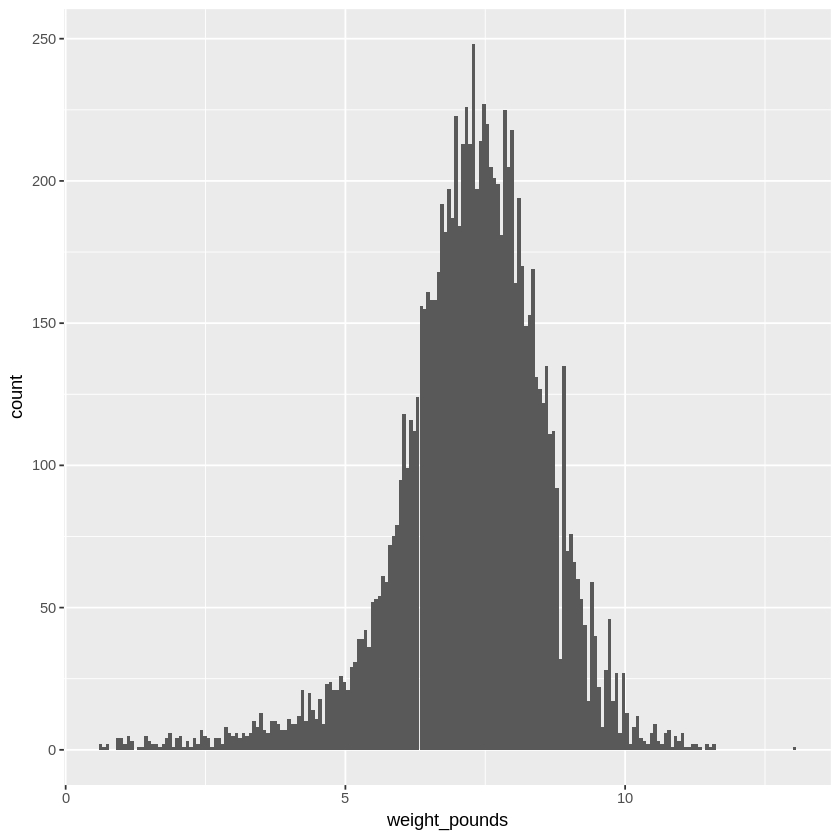

In [10]:
# Display the distribution of baby weights using a histogram
ggplot(
    data = natality_data, 
    aes(x = weight_pounds)
) + geom_histogram(bins = 200)

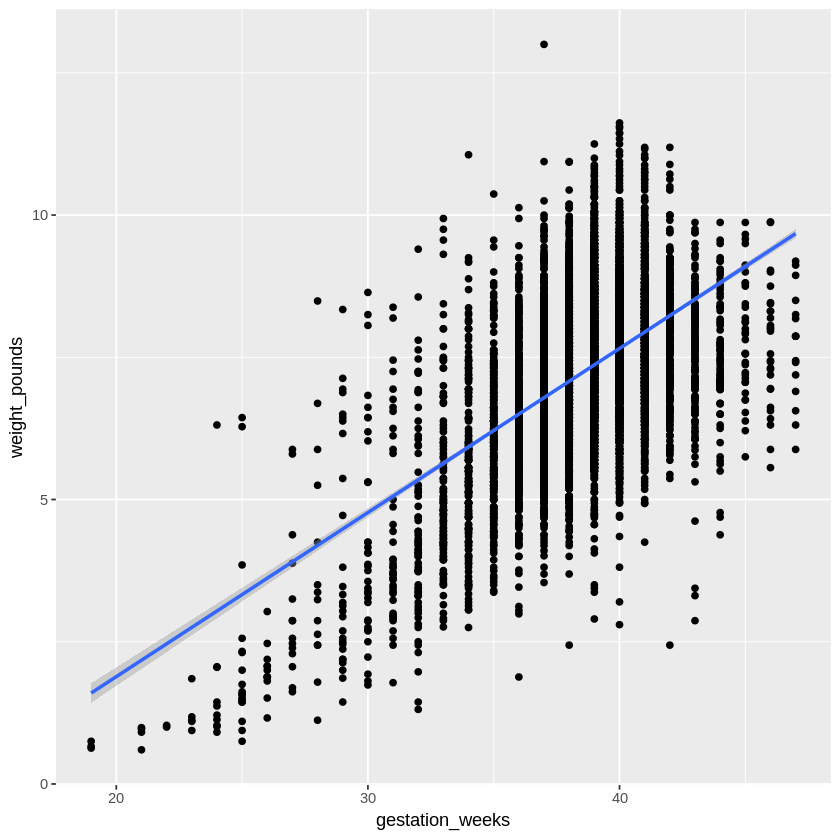

In [11]:
# Display the relationship between gestation weeks and baby weights 
ggplot(
    data = natality_data, 
    aes(x = gestation_weeks, y = weight_pounds)
) + geom_point() + geom_smooth(method = "lm")

### Performing the processing in BigQuery
Create function that finds the number of records and the average weight for each value of the chosen column

In [12]:
get_distinct_values <- function(column_name) {
    query <- paste0(
        'SELECT ', column_name, ', 
            COUNT(1) AS num_babies,
            AVG(weight_pounds) AS avg_wt
        FROM publicdata.samples.natality
        WHERE year > 2000
        GROUP BY ', column_name)
    
    bq_table_download(
        bq_project_query(
            PROJECT_ID, 
            query = query
        )
    )
}

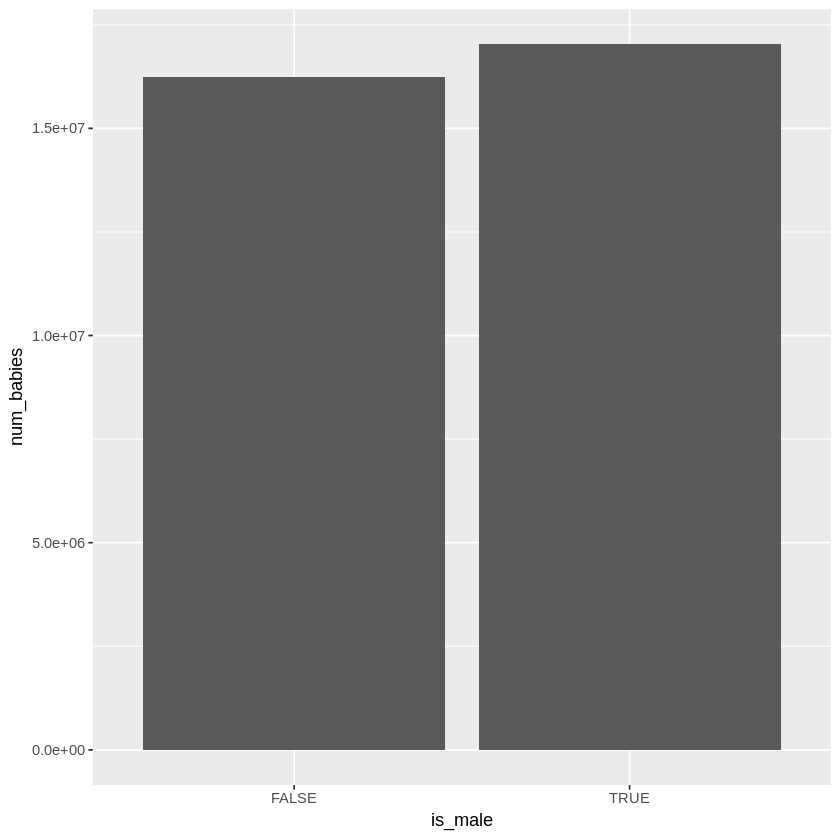

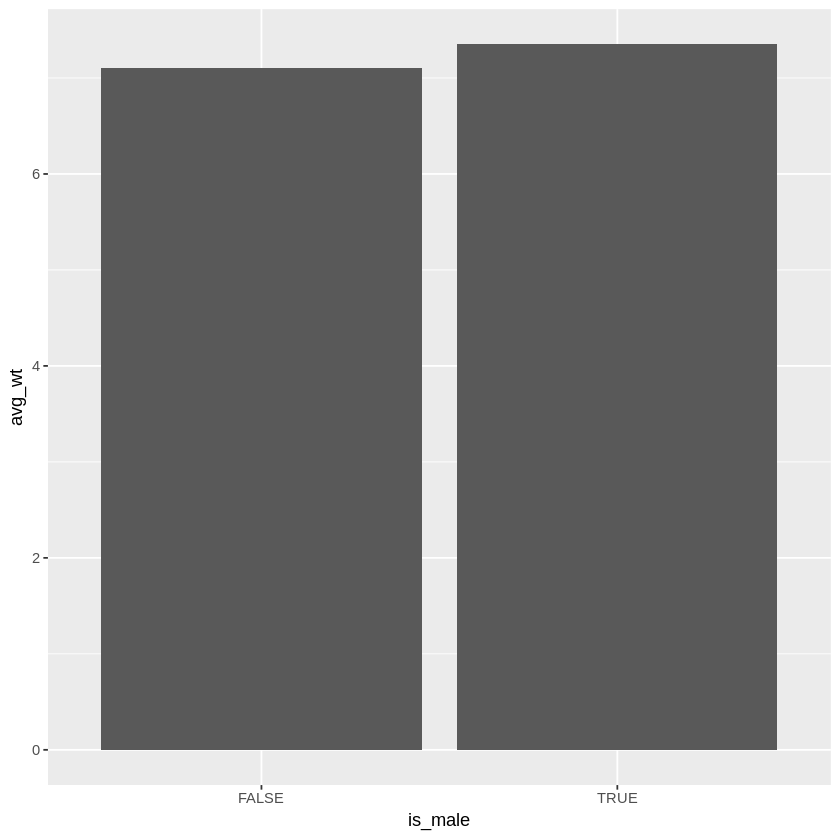

In [13]:
df <- get_distinct_values('is_male')
ggplot(data = df, aes(x = is_male, y = num_babies)) + geom_col()
ggplot(data = df, aes(x = is_male, y = avg_wt)) + geom_col()

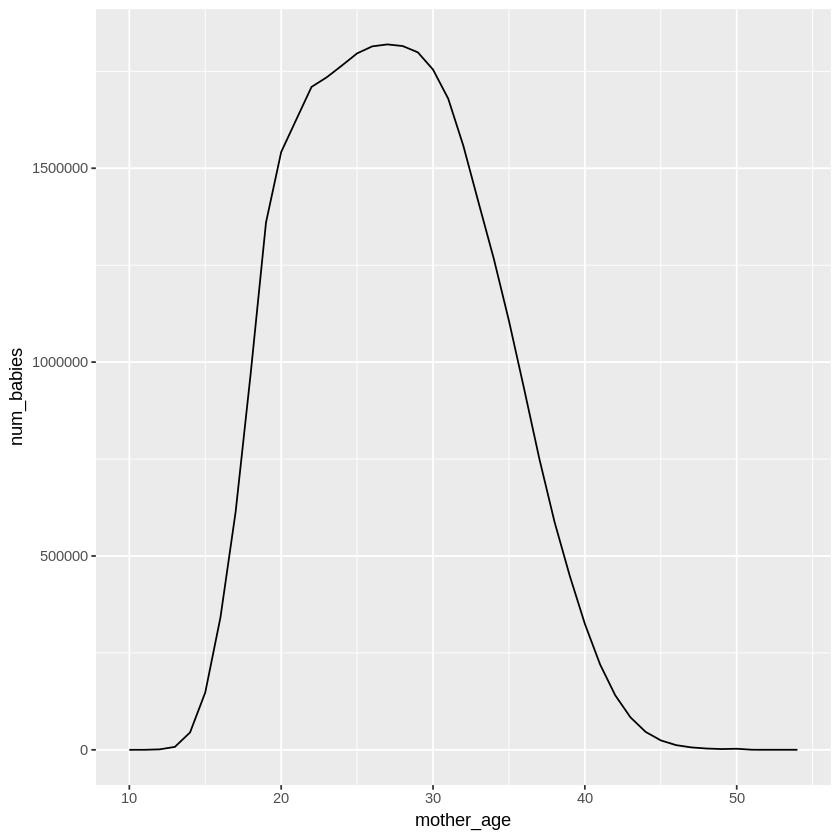

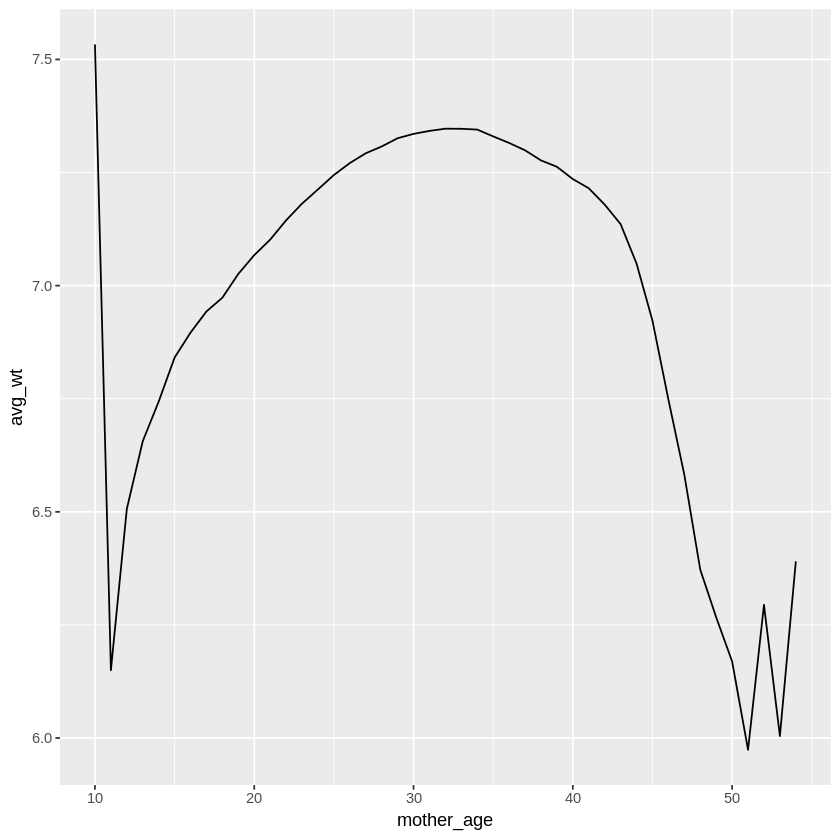

In [14]:
df <- get_distinct_values('mother_age')
ggplot(data = df, aes(x = mother_age, y = num_babies)) + geom_line()
ggplot(data = df, aes(x = mother_age, y = avg_wt)) + geom_line()

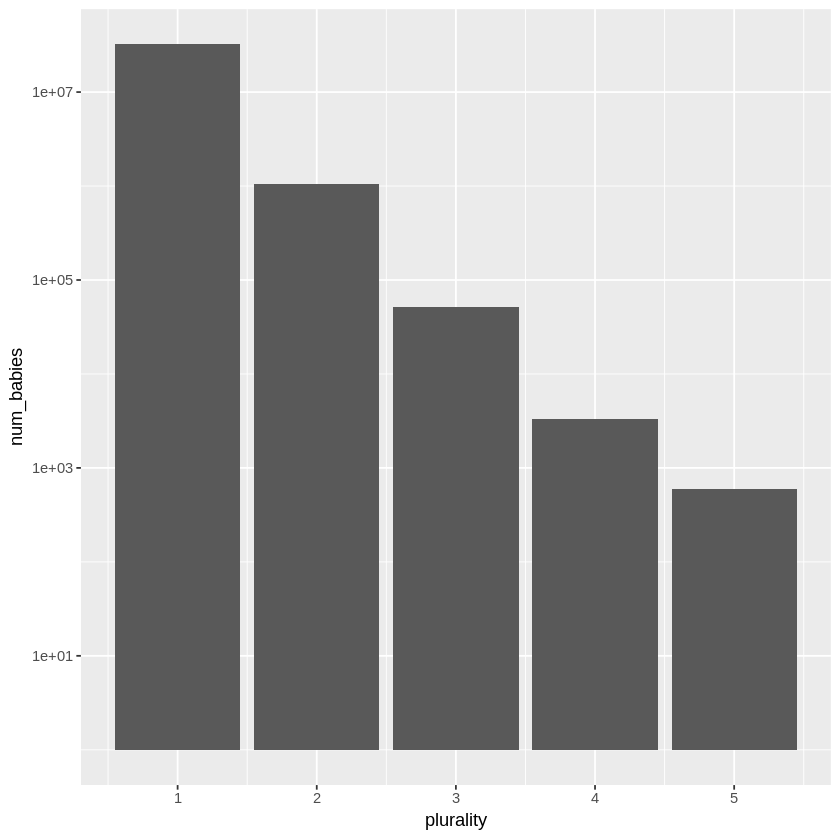

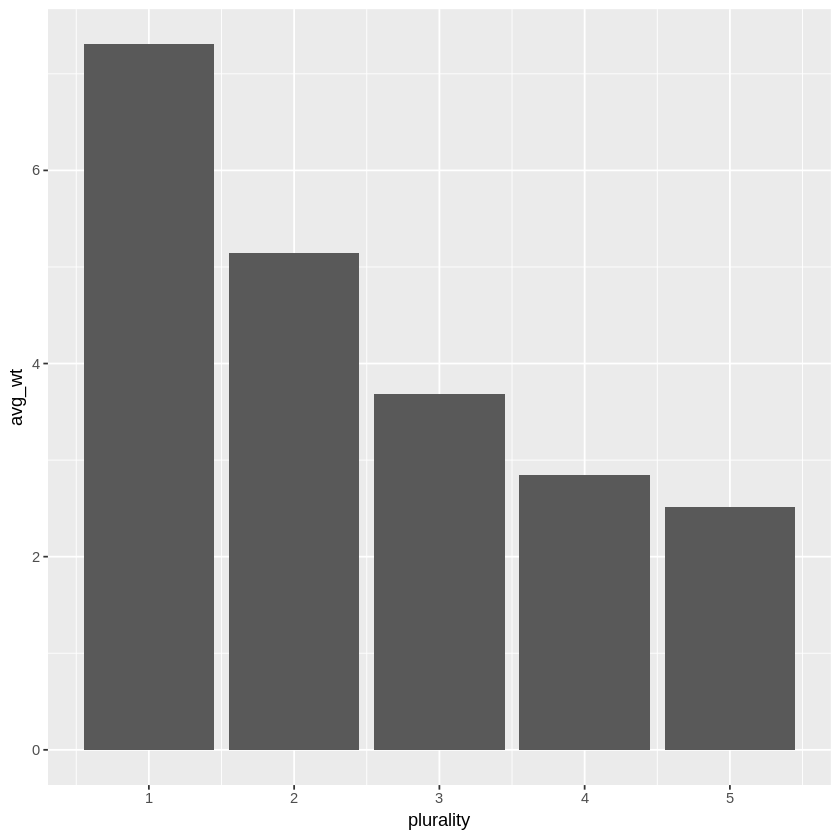

In [15]:
df <- get_distinct_values('plurality')
ggplot(data = df, aes(x = plurality, y = num_babies)) + geom_col() + scale_y_log10()
ggplot(data = df, aes(x = plurality, y = avg_wt)) + geom_col()

Warning message:
“Removed 1 rows containing missing values (position_stack).”
Warning message:
“Removed 1 rows containing missing values (position_stack).”


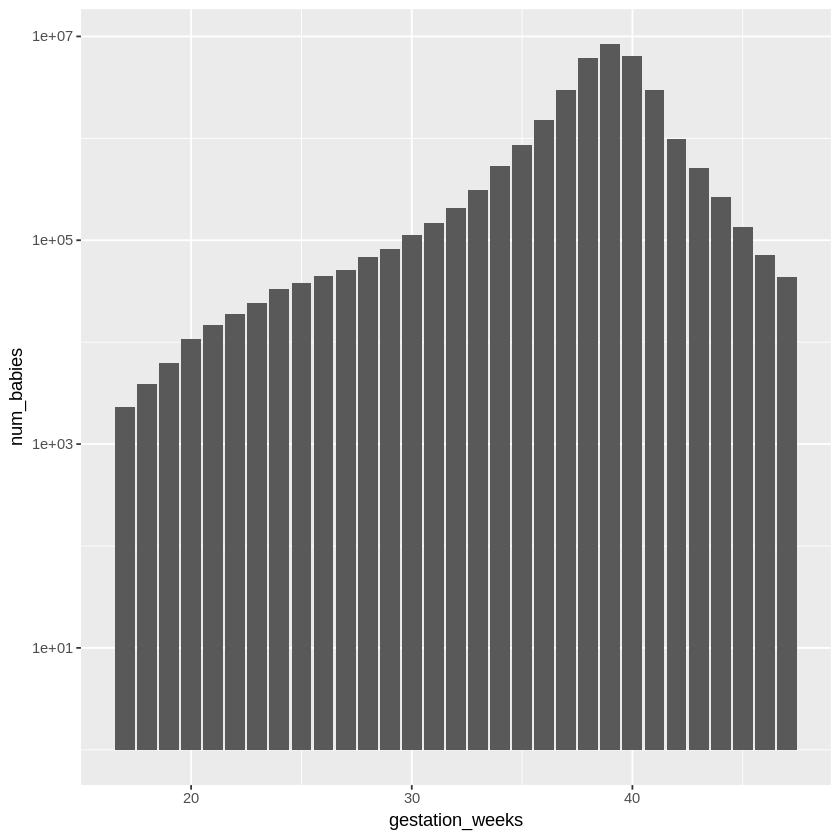

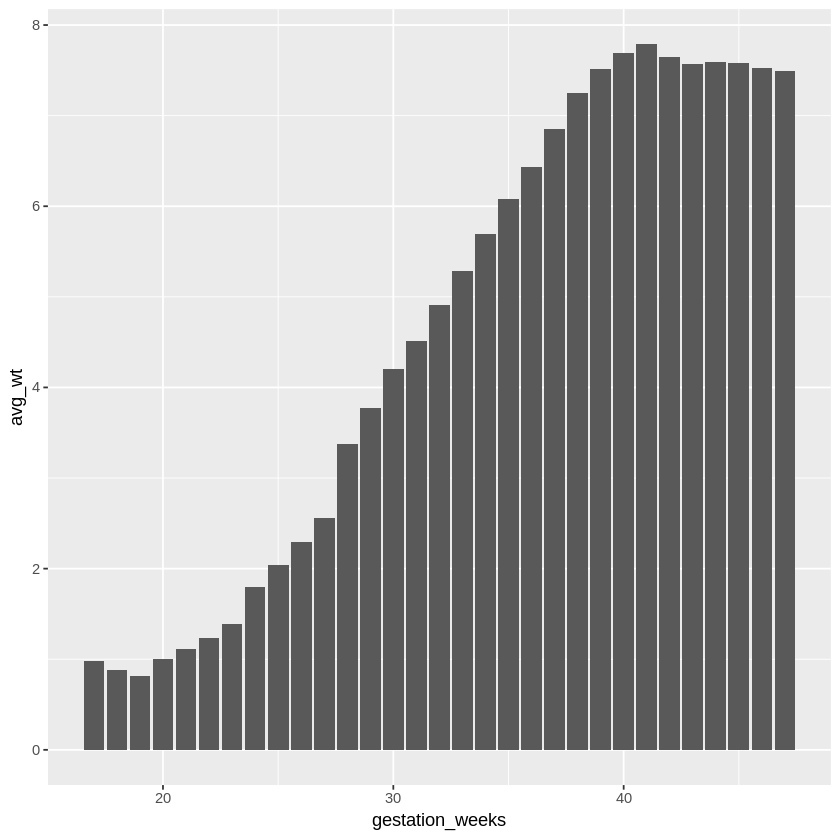

In [16]:
df <- get_distinct_values('gestation_weeks')
ggplot(data = df, aes(x = gestation_weeks, y = num_babies)) + geom_col() + scale_y_log10()
ggplot(data = df, aes(x = gestation_weeks, y = avg_wt)) + geom_col()

# 3. Saving the data as CSV to GCS

In [17]:
# Prepare training and evaluation data from BigQuery
sample_size <- 10000
sql_query <- sprintf(sql_query, sample_size)

train_query <- paste('SELECT * FROM (', sql_query, ') WHERE MOD(CAST(key AS INT64), 100) <= 75')
eval_query <- paste('SELECT * FROM (', sql_query, ') WHERE MOD(CAST(key AS INT64), 100) > 75')

# Load training data to data frame
train_data <- bq_table_download(
    bq_project_query(
        PROJECT_ID, 
        query = train_query
    )
)

# Load evaluation data to data frame
eval_data <- bq_table_download(
    bq_project_query(
        PROJECT_ID, 
        query = eval_query
    )
)

In [18]:
print(paste0("Training instances count: ", nrow(train_data)))
print(paste0("Evaluation instances count: ", nrow(eval_data)))

[1] "Training instances count: 7647"
[1] "Evaluation instances count: 2353"


In [19]:
# Write data frames to a local CSV files, without headers nor row index
dir.create(file.path('data'), showWarnings = FALSE)
write.table(train_data, "data/train_data.csv", row.names = FALSE, col.names = FALSE, sep = ",")
write.table(eval_data, "data/eval_data.csv", row.names = FALSE, col.names = FALSE, sep = ",")

In [20]:
# Upload CSV data to GCS by passing gsutil commands to system
gcs_url <- paste0("gs://", BUCKET_NAME, "/")
command <- paste("gsutil mb", gcs_url)
system(command)
gcs_data_dir <- paste0("gs://", BUCKET_NAME, "/data")
command <- paste("gsutil cp data/*_data.csv", gcs_data_dir)
system(command)

In [21]:
command <- paste("gsutil ls -l", gcs_data_dir)
system(command, intern = TRUE)

[1] "    114917  2020-04-22T18:39:05Z  gs://r-on-gcp/data/eval_data.csv" 
[2] "    373564  2020-04-22T18:39:05Z  gs://r-on-gcp/data/train_data.csv"
[3] "TOTAL: 2 objects, 488481 bytes (477.03 KiB)"

## License

Authors: Daniel Sparing, Khalid Salama

---
**Disclaimer**: This is not an official Google product. The sample code provided for an educational purpose.

---

Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0.

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.